In [2]:
import numpy as np
import oapackage
import progressbar
import tempfile
import matplotlib.pyplot as plt
import random
    
try:  # SciPy >= 0.19
    from scipy.special import comb, logsumexp
except ImportError:
    from scipy.misc import comb, logsumexp


folder_path='C:/Users/vipul/Desktop/Orthogonal_array/'
temp_path='C:/Users/vipul/AppData/Local/Temp/'

In [3]:
array=oapackage.exampleArray(2,1)

def array_stats(array):
    print(array)
    array.showarray()
    print('D-efficiency %f, rank %d' % (array.Defficiency(), array.rank()) )
    print('Generalized wordlength pattern: %s' % str(array.GWLP()))
    
array_stats(array)

def array_write(lst):
    filename = tempfile.mktemp('.oa')
    _=oapackage.writearrayfile(filename, lst, oapackage.ATEXT)
    oapackage.oainfo(filename)

def array_read(filename):
    with open(folder_path+filename, 'r') as f:
        matrix = [[int(num) for num in list(line.strip())] for line in f]
    return matrix

lst=array_read('oa_256_16_5_8.txt')
# lst=array_read('oa_64_7_6_1.txt')

array=oapackage.array_link(lst)
array_stats(array)
np_array=np.array(array)

# n,k=np_array.shape
# print(n,k)
# print(list(np_array[2]))

exampleArray 2: array 6 in OA(16, 2, 2^6)
array_link: 16, 6
array:
  0   0   0   0   0   0
  0   0   0   0   0   0
  0   0   0   1   1   1
  0   0   0   1   1   1
  0   1   1   0   0   1
  0   1   1   0   1   0
  0   1   1   1   0   1
  0   1   1   1   1   0
  1   0   1   0   0   1
  1   0   1   0   1   1
  1   0   1   1   0   0
  1   0   1   1   1   0
  1   1   0   0   1   0
  1   1   0   0   1   1
  1   1   0   1   0   0
  1   1   0   1   0   1
D-efficiency 0.000000, rank 6
Generalized wordlength pattern: (1.0, 0.0, 0.0, 2.5, 1.5, 0.0, 0.0)
array_link: 256, 16
array:
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  1   1   0   0   1   1   0   0   1   1   0   0   1   1   0   0
  1   0   1   0   1   0   1   0   1   0   1   0   1   0   1   0
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
  0   1   1   1   1   0   0   0   1   0   0   0   1   0   0   0
  0   1   1   0   0   1   1   0   0   1   1   0   0   1   1   0
  0   0   1   1   0   0   1   1   0   0 

In [4]:
# Fitness check

def col_combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

def combination_analysis(comb_count,l):
    combination_count,powt=comb_count.shape
    np_compare=np.full((1,powt),l)
    fail_cols=[]
    fail_combs=[]
    print('Expected output combination: ',np_compare)
    print('Number of column combination: ',combination_count,'    Tuple count (2^t): ',powt)
    for i in range(combination_count):
        if(np.any(comb_count[i] != np_compare)):
            fail_cols.append(i)
            fail_combs.append(list(comb_count[i]))
    if(len(fail_cols)>0):
        print('Minimum tuple value: ', np.amin(comb_count))
        print('Maximum tuple value: ', np.amax(comb_count))
    return fail_cols,fail_combs
        

def fitness_check(np_array,t):
    n,k=np_array.shape
    l=int(n/pow(2,t))
    
    comb_value=comb(k,t)
    comb_count = np.zeros((int(comb_value), pow(2,t)))

    def row_analysis(np_row):
        combinations=col_combinations(list(np_row),t) #All combinations for selection of columns
        np_combinations = np.array(list(combinations))
        combination_index=np_combinations.dot(1 << np.arange(np_combinations.shape[-1] - 1, -1, -1)) #BIN to DEC
        for i in range(0,int(comb_value)):
            index=int(combination_index[i])
            comb_count[i][index]=comb_count[i][index]+1

    print('Number of runs (n):',n)
    print('Number of factors (k):',k)
    print('Strength (t):',t, '     2^t:', pow(2,t)) 
    print("Number of ways for selecting columns: ", comb_value)
    column_combinations=col_combinations(range(k),t)
    np_column_combinations = np.array(list(column_combinations))
    for i in progressbar.progressbar(range(0,n)):
            row_analysis(np_array[i])
            
    print(comb_count)
    
    print('Analysing combination results for l')
#     while l > 0:
    print('Checking for l=',l)
    fail_columns,fail_combinations=combination_analysis(comb_count,l)
    if(len(fail_columns)==0):
        print('PASSED FOR l=',l)
        l=0
    else:
        print('FAILED for l=',l)
        print(len(fail_combinations), 'failed column combinations \n')
        tmp = tempfile.mktemp('.oa')
        tmpfile = open(tmp,"w")
        tmpfile.write('l='+str(l)+' tuple count='+str(pow(2,t)) + '\n')
        tmpfile.write('Column Selection  |  Tupple Counts \n')
        tmpfile.write('[                 ] |')
        for i in range(pow(2,t)):
            tmpfile.write(f'{i:3d}')
        tmpfile.write('\n')
        for i in range(len(fail_combinations)):
            record=str(np_column_combinations[fail_columns[i]])+' \n'+ '  '.join(map(str,map(int,fail_combinations[i])))+'\n'
            tmpfile.write(str(record))
        a = np.array(fail_combinations)
        plt.figure(figsize=(100,100))
        plt.imshow(a, interpolation='nearest')
        plt.show()
        print('saved results to \n',tmp)
        l=l-1
    print('-------------------')


# fitness_check(np_array, 5)

In [5]:
lst=array_read('oa_256_16_5_8.txt')
# lst=array_read('oa_64_7_6_1.txt')

array=oapackage.array_link(lst)
array_stats(array)
np_array=np.array(array)

fitness_check(np_array, 1)
# fitness_check(np_array, 2)
# fitness_check(np_array, 3)
# fitness_check(np_array, 4)
# fitness_check(np_array, 5)
# fitness_check(np_array, 6)
# fitness_check(np_array, 7)
# fitness_check(np_array, 8)




100% (256 of 256) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


array_link: 256, 16
array:
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  1   1   0   0   1   1   0   0   1   1   0   0   1   1   0   0
  1   0   1   0   1   0   1   0   1   0   1   0   1   0   1   0
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
  0   1   1   1   1   0   0   0   1   0   0   0   1   0   0   0
  0   1   1   0   0   1   1   0   0   1   1   0   0   1   1   0
  0   0   1   1   0   0   1   1   0   0   1   1   0   0   1   1
  0   1   0   1   0   1   0   1   0   1   0   1   0   1   0   1
  1   0   0   1   1   1   0   0   1   0   1   0   0   0   0   0
  1   1   0   0   1   0   1   0   1   0   0   1   0   0   0   0
  1   0   1   0   1   0   0   1   1   1   0   0   0   0   0   0
  1   0   1   1   0   1   0   0   0   1   0   0   0   1   0   0
  1   1   0   1   0   0   1   0   0   0   1   0   0   0   1   0
  1   0   0   0   0   1   1   1   0   1   1   1   0   1   1   1
  1   1   1   1   1   1   1   1   0   0   0   0   0   0   0   0
  1   1   0  

Deleted row-

  1% (4 of 255) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00

 [12]
Number of runs (n): 255
Number of factors (k): 16
Strength (t): 4      2^t: 16
Number of ways for selecting columns:  1820.0


100% (255 of 255) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


[[16. 16. 16. ... 15. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 ...
 [16. 16. 15. ... 16. 16. 16.]
 [16. 16. 15. ... 16. 16. 16.]
 [16. 16. 15. ... 16. 16. 16.]]
Analysing combination results for l
Checking for l= 15
Expected output combination:  [[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]]
Number of column combination:  1820     Tuple count (2^t):  16
Minimum tuple value:  15.0
Maximum tuple value:  16.0
FAILED for l= 15
1820 failed column combinations 



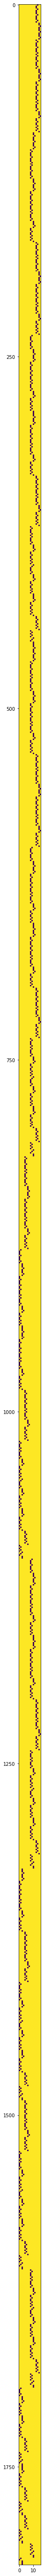

  5% (13 of 254) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02

saved results to 
 C:\Users\vipul\AppData\Local\Temp\tmpofkv4f4f.oa
-------------------
Deleted row- [140]
Number of runs (n): 254
Number of factors (k): 16
Strength (t): 4      2^t: 16
Number of ways for selecting columns:  1820.0


100% (254 of 254) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


[[16. 16. 16. ... 15. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 ...
 [16. 16. 15. ... 16. 16. 16.]
 [16. 16. 15. ... 16. 16. 16.]
 [16. 16. 15. ... 16. 16. 16.]]
Analysing combination results for l
Checking for l= 15
Expected output combination:  [[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]]
Number of column combination:  1820     Tuple count (2^t):  16
Minimum tuple value:  14.0
Maximum tuple value:  16.0
FAILED for l= 15
1820 failed column combinations 



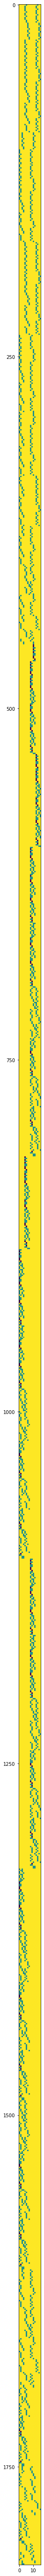

  5% (13 of 253) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02

saved results to 
 C:\Users\vipul\AppData\Local\Temp\tmp0bp56sov.oa
-------------------
Deleted row- [38]
Number of runs (n): 253
Number of factors (k): 16
Strength (t): 4      2^t: 16
Number of ways for selecting columns:  1820.0


100% (253 of 253) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


[[16. 16. 16. ... 15. 16. 16.]
 [16. 16. 15. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 ...
 [16. 16. 15. ... 16. 16. 16.]
 [16. 16. 15. ... 16. 16. 16.]
 [15. 16. 15. ... 16. 16. 16.]]
Analysing combination results for l
Checking for l= 15
Expected output combination:  [[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]]
Number of column combination:  1820     Tuple count (2^t):  16
Minimum tuple value:  13.0
Maximum tuple value:  16.0
FAILED for l= 15
1820 failed column combinations 



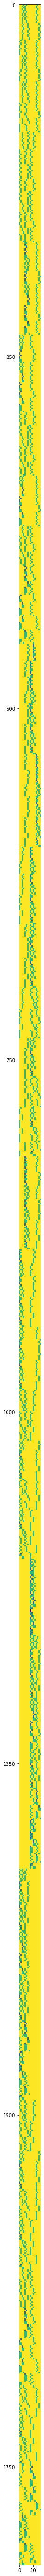

  5% (13 of 252) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02

saved results to 
 C:\Users\vipul\AppData\Local\Temp\tmp91ks8u1n.oa
-------------------
Deleted row- [53]
Number of runs (n): 252
Number of factors (k): 16
Strength (t): 4      2^t: 16
Number of ways for selecting columns:  1820.0


100% (252 of 252) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


[[16. 16. 16. ... 15. 16. 16.]
 [16. 16. 15. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 ...
 [15. 16. 15. ... 16. 16. 16.]
 [16. 16. 15. ... 16. 16. 16.]
 [15. 16. 15. ... 16. 16. 16.]]
Analysing combination results for l
Checking for l= 15
Expected output combination:  [[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]]
Number of column combination:  1820     Tuple count (2^t):  16
Minimum tuple value:  13.0
Maximum tuple value:  16.0
FAILED for l= 15
1820 failed column combinations 



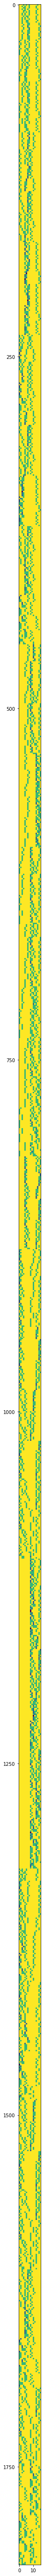

  5% (13 of 251) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02

saved results to 
 C:\Users\vipul\AppData\Local\Temp\tmpida0bhc4.oa
-------------------
Deleted row- [197]
Number of runs (n): 251
Number of factors (k): 16
Strength (t): 4      2^t: 16
Number of ways for selecting columns:  1820.0


100% (251 of 251) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


[[16. 16. 16. ... 15. 16. 16.]
 [16. 16. 15. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 ...
 [15. 16. 14. ... 16. 16. 16.]
 [16. 16. 15. ... 16. 16. 16.]
 [15. 16. 15. ... 16. 16. 16.]]
Analysing combination results for l
Checking for l= 15
Expected output combination:  [[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]]
Number of column combination:  1820     Tuple count (2^t):  16
Minimum tuple value:  13.0
Maximum tuple value:  16.0
FAILED for l= 15
1820 failed column combinations 



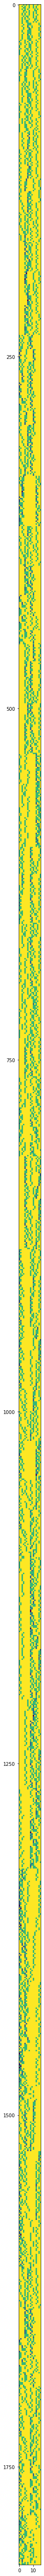

  2% (7 of 250) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00

saved results to 
 C:\Users\vipul\AppData\Local\Temp\tmp9y7_ppa3.oa
-------------------
Deleted row- [174]
Number of runs (n): 250
Number of factors (k): 16
Strength (t): 4      2^t: 16
Number of ways for selecting columns:  1820.0


100% (250 of 250) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


[[16. 16. 15. ... 15. 16. 16.]
 [16. 16. 14. ... 16. 16. 16.]
 [16. 16. 15. ... 16. 16. 16.]
 ...
 [15. 16. 14. ... 16. 16. 16.]
 [16. 16. 15. ... 16. 16. 16.]
 [15. 16. 14. ... 16. 16. 16.]]
Analysing combination results for l
Checking for l= 15
Expected output combination:  [[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]]
Number of column combination:  1820     Tuple count (2^t):  16
Minimum tuple value:  12.0
Maximum tuple value:  16.0
FAILED for l= 15
1820 failed column combinations 



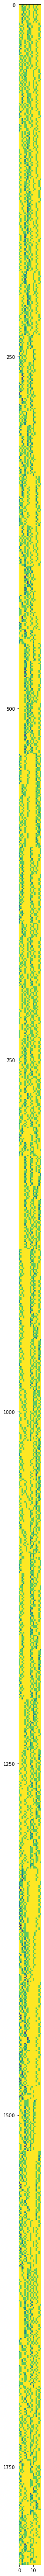

saved results to 
 C:\Users\vipul\AppData\Local\Temp\tmplp_h_a7u.oa
-------------------


In [6]:
def remove_random(np_array,count):
    n=np_array.shape[0]
    random_index = random.sample(range(n), count)
    print('Deleted row-', random_index)
    new_array=np.delete(np_array,random_index,0)
    return new_array

def remove_row(np_array,row_number):
    print('Deleted row-', row_number)
    new_array=np.delete(np_array,row_number,0)
    return new_array

new_array=remove_random(new_array,1)
fitness_check(new_array, 4)


In [8]:
           
def row_fitness_check(np_array,t):
    n,k=np_array.shape
    l=int(n/pow(2,t))
    
    comb_value=comb(k,t)
    comb_count = np.zeros((int(comb_value), 1))

    for row in np_array:
        print(row)
        combinations=col_combinations(row,t) #All combinations for selection of columns
        np_combinations = np.array(combinations)
        
        combination_index=np_combinations.dot(1 << np.arange(np_combinations.shape[-1] - 1, -1, -1)) #BIN to DEC
        for i in range(0,int(comb_value)):
            index=int(combination_index[i])
            comb_count[i]=index
    print(comb_count)
    return comb_count

row_fitness_check(array,4)

0


IndexError: tuple index out of range

In [9]:
def fitness_row_check(np_array,t):
    n,k=np_array.shape
    l=int(n/pow(2,t))
    
    comb_value=int(comb(k,t))
    comb_count = np.zeros((n, comb_value))

    tmp = tempfile.mktemp('.csv')
    tmpfile = open(tmp,"w")
#     tmpfile.write('l='+str(l)+' tuple count='+str(pow(2,t)) + '\n')
#     tmpfile.write('Row  |  Combination values \n')
    
    def row_analysis(np_row,i):
        combinations=col_combinations(list(np_row),t) #All combinations for selection of columns
        np_combinations = np.array(list(combinations))
        combination_value=np_combinations.dot(1 << np.arange(np_combinations.shape[-1] - 1, -1, -1)) #BIN to DEC
#         record=str(i)+ ' | ' + np.array_str(np_row) + '1s: ' + str(np.count_nonzero(np_row)) + '\n'+ '  '.join(map(str,map(int,combination_value)))+'\n'
#         record=str(i) + ',' + np.array_str(np_row) + ',' +  ' , '.join(map(str,map(int,combination_value)))+'\n'
        record= ' , '.join(map(str,map(int,combination_value)))+'\n'
#         print(record)
        tmpfile.write(str(record))

    print('Number of runs (n):',n)
    print('Number of factors (k):',k)
    print('Strength (t):',t, '     2^t:', pow(2,t)) 
    print("Number of ways for selecting columns: ", comb_value)
    column_combinations=col_combinations(range(k),t)
    np_column_combinations = np.array(list(column_combinations))
    for i in progressbar.progressbar(range(0,n)):
            row_analysis(np_array[i],i)
            
    print('saved combination results to \n',tmp)
    print('-------------------')
    return tmp


lst=array_read('oa_256_16_5_8.txt')
# lst=array_read('oa_64_7_6_1.txt')

array=oapackage.array_link(lst)
array_stats(array)
np_array=np.array(array)

fitness_row_check(np_array, 5)

  2% (7 of 256) |                        | Elapsed Time: 0:00:00 ETA:   0:00:04

array_link: 256, 16
array:
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  1   1   0   0   1   1   0   0   1   1   0   0   1   1   0   0
  1   0   1   0   1   0   1   0   1   0   1   0   1   0   1   0
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
  0   1   1   1   1   0   0   0   1   0   0   0   1   0   0   0
  0   1   1   0   0   1   1   0   0   1   1   0   0   1   1   0
  0   0   1   1   0   0   1   1   0   0   1   1   0   0   1   1
  0   1   0   1   0   1   0   1   0   1   0   1   0   1   0   1
  1   0   0   1   1   1   0   0   1   0   1   0   0   0   0   0
  1   1   0   0   1   0   1   0   1   0   0   1   0   0   0   0
  1   0   1   0   1   0   0   1   1   1   0   0   0   0   0   0
  1   0   1   1   0   1   0   0   0   1   0   0   0   1   0   0
  1   1   0   1   0   0   1   0   0   0   1   0   0   0   1   0
  1   0   0   0   0   1   1   1   0   1   1   1   0   1   1   1
  1   1   1   1   1   1   1   1   0   0   0   0   0   0   0   0
  1   1   0  

100% (256 of 256) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


saved combination results to 
 C:\Users\vipul\AppData\Local\Temp\tmpz5kny1sq.csv
-------------------


'C:\\Users\\vipul\\AppData\\Local\\Temp\\tmpz5kny1sq.csv'

In [10]:
def array_sort(np_array):
    n,k=np_array.shape
    sort_array=np_array.dot(1 << np.arange(np_array.shape[-1] - 1, -1, -1))
    arr1inds = sort_array.argsort()
    sorted_sort_array=sort_array[arr1inds[::-1]]
#     print(sorted_sort_array)
    sorted_np_array=np_array[arr1inds[::-1]]
    print('Sorted np array-')
    print(sorted_np_array)
    return(sorted_np_array)

# lst=array_read('oa_256_16_5_8.txt')
# lst=array_read('oa_64_7_6_1.txt')
lst=array_read('oa_16_15_2_4.txt')

array=oapackage.array_link(lst)
array_stats(array)
np_array=np.array(array)


np_array=array_sort(np_array)
# fitness_row_check(np_array, 4)
# fitness_check(np_array, 4)

# fitness_check(np_array, 5)
# fitness_row_check(np_array, 5)

# np_array=remove_row(np_array, 250)
fitness_check(np_array, 2)
fitness_row_check(np_array, 2)

100% (16 of 16) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (16 of 16) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


array_link: 16, 15
array:
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  1   0   1   0   1   0   1   0   0   0   0   1   1   1   1
  0   1   1   0   0   1   1   0   0   1   1   0   0   1   1
  1   1   0   0   1   1   0   0   1   0   1   0   1   0   1
  0   0   0   1   1   1   1   0   0   1   1   1   1   0   0
  1   0   1   1   0   1   0   0   1   1   0   0   1   1   0
  0   1   1   1   1   0   0   0   1   1   0   1   0   0   1
  1   1   0   1   0   0   1   0   1   0   1   1   0   1   0
  0   0   0   0   0   0   0   1   1   1   1   1   1   1   1
  1   0   1   0   1   0   1   1   1   1   1   0   0   0   0
  0   1   1   0   0   1   1   1   1   0   0   1   1   0   0
  1   1   0   0   1   1   0   1   0   1   0   1   0   1   0
  0   0   0   1   1   1   1   1   1   0   0   0   0   1   1
  1   0   1   1   0   1   0   1   0   0   1   1   0   0   1
  0   1   1   1   1   0   0   1   0   0   1   0   1   1   0
  1   1   0   1   0   0   1   1   0   1   0   0   1   0   1
D-efficiency 0

'C:\\Users\\vipul\\AppData\\Local\\Temp\\tmp4wthugwb.csv'

In [32]:
def test_removal(selected_np):
    n,k=selected_np.shape
    comparison_check=np.ones((1, k))
    passing=[]
    for i in progressbar.progressbar(range(int(n/2))):
        for j in range (int(n/2),n):
            comparison_result=selected_np[i]+selected_np[j]
            if np.all(comparison_check == comparison_result):
                passing.append((i,j))
    length_passing=len(passing)
    if length_passing > 0:
        print('Selection can be reduced by selecting pairs-')
        print(passing)
    else:
        print('Selection cannot be reduced')
    return passing
        
def reduction_test(np_array, t):
    n,k=np_array.shape
    np_array=array_sort(np_array)
    tmp_file=fitness_row_check(np_array, t)
    combination_np=np.genfromtxt(tmp_file,delimiter=',',dtype=None)
    no_tuples=pow(2,t)
    l=n/no_tuples
    start_row=(no_tuples-2)*l
    print('From combination results')
    print('Selecting rows ', start_row, ' to ', n)
    selected_rows=combination_np[int(start_row):]
#     print(selected_rows)
    result = np.where(selected_rows > 1)
#     print(result)
    end_col=result[1][0]
    print('Selecting columns 0 to ', end_col)
    selected=selected_rows[:,:end_col]
    print(selected)
    print('Checking rows for reduction')
    test_removal(selected)
    
lst=array_read('oa_16_15_2_4.txt')

array=oapackage.array_link(lst)
array_stats(array)
np_array=np.array(array)

reduction_test(np_array, 2)
    
    
    

100% (16 of 16) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


array_link: 16, 15
array:
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  1   0   1   0   1   0   1   0   0   0   0   1   1   1   1
  0   1   1   0   0   1   1   0   0   1   1   0   0   1   1
  1   1   0   0   1   1   0   0   1   0   1   0   1   0   1
  0   0   0   1   1   1   1   0   0   1   1   1   1   0   0
  1   0   1   1   0   1   0   0   1   1   0   0   1   1   0
  0   1   1   1   1   0   0   0   1   1   0   1   0   0   1
  1   1   0   1   0   0   1   0   1   0   1   1   0   1   0
  0   0   0   0   0   0   0   1   1   1   1   1   1   1   1
  1   0   1   0   1   0   1   1   1   1   1   0   0   0   0
  0   1   1   0   0   1   1   1   1   0   0   1   1   0   0
  1   1   0   0   1   1   0   1   0   1   0   1   0   1   0
  0   0   0   1   1   1   1   1   1   0   0   0   0   1   1
  1   0   1   1   0   1   0   1   0   0   1   1   0   0   1
  0   1   1   1   1   0   0   1   0   0   1   0   1   1   0
  1   1   0   1   0   0   1   1   0   1   0   0   1   0   1
D-efficiency 0

In [29]:
lst=array_read('oa_56_28_3.txt')

array=oapackage.array_link(lst)
array_stats(array)
np_array=np.array(array)

reduction_test(np_array, 3)

N/A% (0 of 56) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

array_link: 56, 28
array:
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   1   0   0   1   1   1   1   0   0   1   0   0   1   0   1   0   0   1   1   1   1   0   0   1   0
  0   0   0   0   1   0   0   1   1   1   1   0   0   1   0   0   1   0   1   0   0   1   1   1   1   0   0   1
  0   1   0   0   0   1   0   0   1   1   1   1   0   0   0   1   0   1   0   1   0   0   1   1   1   1   0   0
  0   0   1   0   0   0   1   0   0   1   1   1   1   0   0   0   1   0   1   0   1   0   0   1   1   1   1   0
  0   0   0   1   0   0   0   1   0   0   1   1   1   1   0   0   0   1   0   1   0   1   0   0   1   1   1   1
  0   1   0   0   1   0   0   0   1   0   0   1   1   1   0   1   0   0   1   0   1   0   1   0   0   1   1   1
  0   1   1   0   0   1   0   0   0   1   0   0   1   1   0   1   1   0   0   1   0   1   0   1   0   0   1   1
  0   1   1   1   0   0   1   0   0   0   1   0   0   1   0   1   1   1   0   

100% (56 of 56) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


saved combination results to 
 C:\Users\vipul\AppData\Local\Temp\tmptblqb52w.csv
-------------------
From combination results
Selecting rows  42.0  to  56
Selecting columns 0 to  26
[[1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 1]
 [1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0]
 [1 0 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1]
 [1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0]
 [1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 1]
 [1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1]
 [1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0]
 [0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0]
 [0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0]
 [0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0]
 [0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1]
 [0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Selection cannot be reduced


In [34]:
lst=array_read('oa_1024_12_7.txt')

array=oapackage.array_link(lst)
array_stats(array)
np_array=np.array(array)

reduction_test(np_array, 7)

  1% (13 of 1024) |                      | Elapsed Time: 0:00:00 ETA:  00:00:00

array_link: 1024, 12
array:
  0   0   0   0   0   0   0   0   0   0   0   0
  1   1   1   0   0   0   0   0   0   0   0   0
  1   0   0   1   0   0   0   0   0   0   0   0
  0   1   1   1   0   0   0   0   0   0   0   0
  0   1   0   0   1   0   0   0   0   0   0   0
  1   0   1   0   1   0   0   0   0   0   0   0
  1   1   0   1   1   0   0   0   0   0   0   0
  0   0   1   1   1   0   0   0   0   0   0   0
  1   1   0   0   0   1   0   0   0   0   0   0
  0   0   1   0   0   1   0   0   0   0   0   0
  0   1   0   1   0   1   0   0   0   0   0   0
  1   0   1   1   0   1   0   0   0   0   0   0
  1   0   0   0   1   1   0   0   0   0   0   0
  0   1   1   0   1   1   0   0   0   0   0   0
  0   0   0   1   1   1   0   0   0   0   0   0
  1   1   1   1   1   1   0   0   0   0   0   0
  1   0   0   0   0   0   1   0   0   0   0   0
  0   1   1   0   0   0   1   0   0   0   0   0
  0   0   0   1   0   0   1   0   0   0   0   0
  1   1   1   1   0   0   1   0   0   0   0   0
  1   1   0 

100% (1024 of 1024) |####################| Elapsed Time: 0:00:04 Time:  0:00:04


saved combination results to 
 C:\Users\vipul\AppData\Local\Temp\tmpc07v061v.csv
-------------------


100% (8 of 8) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


From combination results
Selecting rows  1008.0  to  1024
Selecting columns 0 to  6
[[1 1 1 1 1 1]
 [1 1 1 0 0 0]
 [1 1 0 1 1 0]
 [1 1 0 0 0 1]
 [1 0 1 1 0 1]
 [1 0 1 0 1 0]
 [1 0 0 1 0 0]
 [1 0 0 0 1 1]
 [0 1 1 1 0 0]
 [0 1 1 0 1 1]
 [0 1 0 1 0 1]
 [0 1 0 0 1 0]
 [0 0 1 1 1 0]
 [0 0 1 0 0 1]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]]
Checking rows for reduction
Selection can be reduced by selecting pairs-
[(0, 15), (1, 14), (2, 13), (3, 12), (4, 11), (5, 10), (6, 9), (7, 8)]


In [33]:
lst=array_read('oa_2048_16_7.txt')

array=oapackage.array_link(lst)
array_stats(array)
np_array=np.array(array)

reduction_test(np_array, 7)

N/A% (0 of 2048) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

array_link: 2048, 16
array:
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  1   1   0   0   1   0   0   0   0   0   0   0   0   0   0   1
  0   1   1   0   0   1   0   0   0   0   0   0   0   0   0   1
  1   0   1   0   1   1   0   0   0   0   0   0   0   0   0   0
  0   0   1   1   0   0   1   0   0   0   0   0   0   0   0   1
  1   1   1   1   1   0   1   0   0   0   0   0   0   0   0   0
  0   1   0   1   0   1   1   0   0   0   0   0   0   0   0   0
  1   0   0   1   1   1   1   0   0   0   0   0   0   0   0   1
  0   0   0   1   1   0   0   1   0   0   0   0   0   0   0   1
  1   1   0   1   0   0   0   1   0   0   0   0   0   0   0   0
  0   1   1   1   1   1   0   1   0   0   0   0   0   0   0   0
  1   0   1   1   0   1   0   1   0   0   0   0   0   0   0   1
  0   0   1   0   1   0   1   1   0   0   0   0   0   0   0   0
  1   1   1   0   0   0   1   1   0   0   0   0   0   0   0   1
  0   1   0   0   1   1   1   1   0   0   0   0   0   0   0   1
  1   0   0 

100% (2048 of 2048) |####################| Elapsed Time: 0:01:57 Time:  0:01:57


saved combination results to 
 C:\Users\vipul\AppData\Local\Temp\tmp8qy2efjn.csv
-------------------


100% (16 of 16) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


From combination results
Selecting rows  2016.0  to  2048
Selecting columns 0 to  10
[[1 1 1 1 1 0 1 0 0 0]
 [1 1 1 1 0 1 1 0 1 1]
 [1 1 1 0 1 1 1 1 1 0]
 [1 1 1 0 0 0 1 1 0 1]
 [1 1 0 1 1 1 0 1 1 1]
 [1 1 0 1 0 0 0 1 0 0]
 [1 1 0 0 1 0 0 0 0 1]
 [1 1 0 0 0 1 0 0 1 0]
 [1 0 1 1 1 0 0 1 1 0]
 [1 0 1 1 0 1 0 1 0 1]
 [1 0 1 0 1 1 0 0 0 0]
 [1 0 1 0 0 0 0 0 1 1]
 [1 0 0 1 1 1 1 0 0 1]
 [1 0 0 1 0 0 1 0 1 0]
 [1 0 0 0 1 0 1 1 1 1]
 [1 0 0 0 0 1 1 1 0 0]
 [0 1 1 1 1 1 0 1 0 0]
 [0 1 1 1 0 0 0 1 1 1]
 [0 1 1 0 1 0 0 0 1 0]
 [0 1 1 0 0 1 0 0 0 1]
 [0 1 0 1 1 0 1 0 1 1]
 [0 1 0 1 0 1 1 0 0 0]
 [0 1 0 0 1 1 1 1 0 1]
 [0 1 0 0 0 0 1 1 1 0]
 [0 0 1 1 1 1 1 0 1 0]
 [0 0 1 1 0 0 1 0 0 1]
 [0 0 1 0 1 0 1 1 0 0]
 [0 0 1 0 0 1 1 1 1 1]
 [0 0 0 1 1 0 0 1 0 1]
 [0 0 0 1 0 1 0 1 1 0]
 [0 0 0 0 1 1 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0]]
Checking rows for reduction
Selection cannot be reduced
